In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

In [3]:
def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

In [4]:
max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

combined_df.head()

,time,cpu_temp,inlet_temp,it_power,fan_speed
0,4718,55.766525,22.468243,177.345436,3929.161963
1,4719,55.608490,22.468213,177.350546,3929.225715
2,4720,55.446706,22.468188,177.362315,3929.311931
3,4721,55.238044,22.468170,177.380743,3929.420613
4,4721,54.960208,22.468170,177.380743,3929.420613


In [5]:
combined_df.to_csv("../data/combined_df.csv", index=False)

In [6]:
df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

Shape of Final Dataframe = (4255, 5)


In [7]:
scalers = {
    'cpu_temp': MinMaxScaler(),
    'inlet_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    'fan_speed': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

In [8]:
def prepare_data(scaled_df, seq_length=8, k_step=24):

    # Define the input and output features
    features_cols = ['cpu_temp', 'inlet_temp', 'it_power']
    exogenous_col = 'fan_speed'
    output_col = 'cpu_temp'

    # Create sequences
    features = []
    exogenous = []
    outputs = []
    for i in range(len(scaled_df) - seq_length - k_step + 1):
        features.append(scaled_df[features_cols].iloc[i:i + seq_length].values)
        exogenous.append(scaled_df[exogenous_col].iloc[i + seq_length:i + seq_length + k_step].values)
        outputs.append(scaled_df[output_col].iloc[i + seq_length:i + seq_length + k_step].values)

    features = np.array(features)
    exogenous = np.array(exogenous).reshape(-1, k_step, 1)
    outputs = np.array(outputs).reshape(-1, k_step, 1)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    exogenous = torch.tensor(exogenous, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    # Split into train and test
    split_ratio = 0.8
    split_index = int(len(features) * split_ratio)
    train_features, test_features = features[:split_index], features[split_index:]
    train_exogenous, test_exogenous = exogenous[:split_index], exogenous[split_index:]
    train_outputs, test_outputs = outputs[:split_index], outputs[split_index:]

    train_dataset = TensorDataset(train_features, train_exogenous, train_outputs)
    test_dataset = TensorDataset(test_features, test_exogenous, test_outputs)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, outputs, split_index

In [14]:
import torch
import torch.nn as nn

class DualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step):
        super(DualInputAttentionLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.k_step = k_step
        self.input_size = input_size

        # Input attention
        self.attention_weight = nn.Linear(lstm_hidden_size, 1, bias=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

        # LSTM layer
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)

        # Exogenous Variables
        self.exogenous_flatten = nn.Flatten()

        # Dense layers
        self.dense1 = nn.Linear(lstm_hidden_size + 1, dense_hidden_size)  # +1 for the exogenous input
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_hidden_size, 1) # Output is 1 to predict cpu_temp


    def forward(self, x, exogenous_input):
        batch_size, seq_len, feature_dim = x.shape
        outputs = []

        # Initial hidden and cell states
        h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        
        # average of the 2nd and 3rd past features to use as input
        average_history_features = torch.mean(x[:, :, 1:3], dim =1).unsqueeze(1)


        # Iterative Forecasting
        for k in range(self.k_step):
            # Input Attention
            lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
            attention_weights = self.tanh(self.attention_weight(lstm_out))
            attention_weights = self.softmax(attention_weights)
            weighted_lstm_out = torch.mul(lstm_out, attention_weights)
            lstm_out =  torch.sum(weighted_lstm_out, dim=1)

            # Process exogenous input
            exogenous_curr = self.exogenous_flatten(exogenous_input[:, k].unsqueeze(1))

            # Concatenate LSTM output and exogenous input
            combined = torch.cat([lstm_out, exogenous_curr], dim=1)
            # Pass through dense layers
            dense1_out = self.relu(self.dense1(combined))
            output = self.dense2(dense1_out)
            outputs.append(output)
            
            if k < self.k_step - 1:
                 # Use the predicted output as next input by adding average of past features
                output_expanded = output.unsqueeze(1)
                output_expanded = torch.cat((output_expanded, average_history_features), dim = 2)
                x = torch.cat((x[:, 1:], output_expanded), dim=1)
        return torch.cat(outputs, dim=1)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step, num_attention_heads=2):
        super(DualInputAttentionLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.k_step = k_step
        self.input_size = input_size
        self.num_attention_heads = num_attention_heads

        # Input attention using MultiheadAttention for lstm input
        self.lstm_attention = nn.MultiheadAttention(lstm_hidden_size, num_attention_heads, batch_first=True)

        # LSTM layer
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)

        # Exogenous Variables
        self.exogenous_flatten = nn.Flatten()
        self.exogenous_linear = nn.Linear(1, lstm_hidden_size) # project exogenous to lstm_hidden_size

        # Concatenation Attention
        self.concat_attention_weight = nn.Linear(2 * lstm_hidden_size, 1, bias=False)  # Input is concatenation
        self.softmax = nn.Softmax(dim=1)
        # Dense layers
        self.dense1 = nn.Linear(lstm_hidden_size, dense_hidden_size)  # lstm_hidden_size because weighted combination is taken before concatination
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_hidden_size, 1) # Output is 1 to predict cpu_temp


    def forward(self, x, exogenous_input):
        batch_size, seq_len, feature_dim = x.shape
        outputs = []

        # Initial hidden and cell states
        h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)

        # average of the 2nd and 3rd past features to use as input
        average_history_features = torch.mean(x[:, :, 1:3], dim =1).unsqueeze(1)


        # Iterative Forecasting
        for k in range(self.k_step):
             # LSTM processing
            lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
            
            # Apply MultiheadAttention
            attention_out, _ = self.lstm_attention(lstm_out, lstm_out, lstm_out) #query key value are the same
            lstm_out = torch.mean(attention_out, dim=1)  # Average across sequence dimension

            # Process exogenous input
            exogenous_curr = self.exogenous_flatten(exogenous_input[:, k].unsqueeze(1))
            exogenous_curr = self.exogenous_linear(exogenous_curr.unsqueeze(-1)).squeeze(-1)  #projecting into hidden dimension

            # Concatenation Attention
            concat_input = torch.cat([lstm_out.unsqueeze(1), exogenous_curr.unsqueeze(1)], dim=1)
            # Reshape before applying linear layer
            concat_input_reshaped = concat_input.view(batch_size, -1)
            attention_weights = self.concat_attention_weight(concat_input_reshaped) #shape: (B, 1)
            attention_weights = self.softmax(attention_weights.unsqueeze(1)) #shape: (B, 1, 1)

            weighted_combined = torch.sum(concat_input * attention_weights, dim=1) # weighted_combined shape: (B, H)
           
            # Pass through dense layers
            dense1_out = self.relu(self.dense1(weighted_combined))
            output = self.dense2(dense1_out)
            outputs.append(output)

            if k < self.k_step - 1:
                 # Use the predicted output as next input by adding average of past features
                output_expanded = output.unsqueeze(1)
                output_expanded = torch.cat((output_expanded, average_history_features), dim = 2)
                x = torch.cat((x[:, 1:], output_expanded), dim=1)
        return torch.cat(outputs, dim=1)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step):
        super(DualInputAttentionLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.k_step = k_step
        self.input_size = input_size

        # Input attention using MultiheadAttention
        self.lstm_attention = nn.MultiheadAttention(lstm_hidden_size, num_heads=1, batch_first=True)

        # LSTM layer
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)

        # Exogenous Variables
        self.exogenous_flatten = nn.Flatten()

         # Weighted combination layer
        self.weighted_combine = nn.Linear(lstm_hidden_size + 1, 2) # Maps to weights for LSTM and Exogenous

        # Dense layers
        self.dense1 = nn.Linear(lstm_hidden_size , dense_hidden_size)  # Adjusted input size for weighted combination
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_hidden_size, 1) # Output is 1 to predict cpu_temp

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, exogenous_input):
        batch_size, seq_len, feature_dim = x.shape
        outputs = []

        # Initial hidden and cell states
        h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        
        # average of the 2nd and 3rd past features to use as input
        average_history_features = torch.mean(x[:, :, 1:3], dim=1).unsqueeze(1)


        # Iterative Forecasting
        for k in range(self.k_step):
            # LSTM layer and attention
            lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
            
            # Apply multihead attention
            attn_output, _ = self.lstm_attention(lstm_out, lstm_out, lstm_out)
            # Take the first time step of the attention output
            lstm_out = attn_output[:, -1, :]

            # Process exogenous input
            exogenous_curr = self.exogenous_flatten(exogenous_input[:, k].unsqueeze(1))

            # Prepare for weighted combination (concat)
            # print(lstm_out.shape, exogenous_curr.shape)
            combined_input = torch.cat([lstm_out, exogenous_curr], dim=1)
            
            # Calculate weighted combination
            weights = self.softmax(self.weighted_combine(combined_input))
            weighted_output = weights[:, 0].unsqueeze(1) * lstm_out + weights[:, 1].unsqueeze(1) * exogenous_curr

            # Pass through dense layers
            dense1_out = self.relu(self.dense1(weighted_output))
            output = self.dense2(dense1_out)
            outputs.append(output)
            
            if k < self.k_step - 1:
                 # Use the predicted output as next input by adding average of past features
                output_expanded = output.unsqueeze(1)
                output_expanded = torch.cat((output_expanded, average_history_features), dim = 2)
                x = torch.cat((x[:, 1:], output_expanded), dim=1)
        return torch.cat(outputs, dim=1)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step):
        super(DualInputAttentionLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.k_step = k_step
        self.input_size = input_size

        # Input attention using MultiheadAttention
        self.lstm_attention = nn.MultiheadAttention(lstm_hidden_size, num_heads=1, batch_first=True)

        # LSTM layer
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)

        # Dense layer for exogenous input
        self.exogenous_dense = nn.Linear(1, dense_hidden_size)  # Adjust input size if necessary
        self.exogenous_activation = nn.ReLU()

        # Weighted combination layer
        self.weighted_combine = nn.Linear(lstm_hidden_size + dense_hidden_size, 2)  # Adjusted for new dense size

        # Dense layers
        self.dense1 = nn.Linear(lstm_hidden_size, dense_hidden_size)  # Adjusted input size for weighted combination
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_hidden_size, 1)  # Output is 1 to predict cpu_temp

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, exogenous_input):
        batch_size, seq_len, feature_dim = x.shape
        outputs = []

        # Initial hidden and cell states
        h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)

        # Average of the 2nd and 3rd past features to use as input
        average_history_features = torch.mean(x[:, :, 1:3], dim=1).unsqueeze(1)

        # Iterative Forecasting
        for k in range(self.k_step):
            # LSTM layer and attention
            lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))

            # Apply multihead attention
            attn_output, _ = self.lstm_attention(lstm_out, lstm_out, lstm_out)
            # Take the first time step of the attention output
            lstm_out = attn_output[:, -1, :]

            # Process exogenous input through dense layer
            exogenous_curr = exogenous_input[:, k].unsqueeze(1)
            exogenous_dense_out = self.exogenous_activation(self.exogenous_dense(exogenous_curr))

            # Prepare for weighted combination (concat)
            # print(lstm_out.shape, exogenous_dense_out.squeeze(1).shape)
            combined_input = torch.cat([lstm_out, exogenous_dense_out.squeeze(1)], dim=1)

            # Calculate weighted combination
            weights = self.softmax(self.weighted_combine(combined_input))
            weighted_output = weights[:, 0].unsqueeze(1) * lstm_out + weights[:, 1].unsqueeze(1) * exogenous_dense_out.squeeze(1)

            # Pass through dense layers
            dense1_out = self.relu(self.dense1(weighted_output))
            output = self.dense2(dense1_out)
            outputs.append(output)

            if k < self.k_step - 1:
                # Use the predicted output as the next input by adding average of past features
                output_expanded = output.unsqueeze(1)
                # print(output_expanded.shape, average_history_features.shape)
                output_expanded = torch.cat((output_expanded, average_history_features), dim=2)
                x = torch.cat((x[:, 1:], output_expanded), dim=1)

        return torch.cat(outputs, dim=1)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step):
        super(DualInputAttentionLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.k_step = k_step
        self.input_size = input_size

        # Input attention using MultiheadAttention
        self.lstm_attention = nn.MultiheadAttention(lstm_hidden_size, num_heads=1, batch_first=True)

        # LSTM layer
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)

        # Dense layer for exogenous input
        self.exogenous_dense = nn.Linear(1, dense_hidden_size)  # Adjust input size if necessary
        self.exogenous_activation = nn.ReLU()

        # Weighted combination layer
        self.weighted_combine = nn.Linear(lstm_hidden_size + dense_hidden_size, 2)  # Adjusted for new dense size

        # Dense layers
        self.dense1 = nn.Linear(lstm_hidden_size, dense_hidden_size)  # Adjusted input size for weighted combination
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_hidden_size, k_step)  # Output is k_step to predict multiple steps

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, exogenous_input):
        batch_size, seq_len, feature_dim = x.shape
        # print(x.shape, exogenous_input.shape)

        # Initial hidden and cell states
        h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)

        # LSTM layer and attention
        lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))

        # Apply multihead attention
        attn_output, _ = self.lstm_attention(lstm_out, lstm_out, lstm_out)
        # Take the last time step of the attention output
        lstm_out = attn_output[:, -1, :]

        # Process exogenous input through dense layer
        # Process exogenous input through dense layer and average across k_step if needed
        exogenous_dense_out = self.exogenous_activation(self.exogenous_dense(exogenous_input))
        exogenous_dense_out = torch.mean(exogenous_dense_out, dim=1)  # Collapse to (batch_size, dense_hidden_size)

        # Prepare for weighted combination (concat)
        combined_input = torch.cat([lstm_out, exogenous_dense_out], dim=1)

        # Calculate weighted combination
        weights = self.softmax(self.weighted_combine(combined_input))
        weighted_output = weights[:, 0].unsqueeze(1) * lstm_out + weights[:, 1].unsqueeze(1) * exogenous_dense_out

        # Pass through dense layers
        dense1_out = self.relu(self.dense1(weighted_output))
        outputs = self.dense2(dense1_out)  # Predict k steps directly

        return outputs


In [44]:
## lstm decoder

import torch
import torch.nn as nn
import torch.nn.functional as F

class DualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step):
        super(DualInputAttentionLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.k_step = k_step
        self.input_size = input_size

        # Input attention using MultiheadAttention
        self.lstm_attention = nn.MultiheadAttention(lstm_hidden_size, num_heads=1, batch_first=True)

        # LSTM encoder
        self.lstm_encoder = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)

        # LSTM decoder
        self.lstm_decoder = nn.LSTM(1, lstm_hidden_size, batch_first=True)

        # Dense layer for exogenous input
        self.exogenous_dense = nn.Linear(1, dense_hidden_size)  # Adjust input size if necessary
        self.exogenous_activation = nn.ReLU()

        # Weighted combination layer
        self.weighted_combine = nn.Linear(lstm_hidden_size + dense_hidden_size, 2)  # Adjusted for new dense size

        # Dense layers
        self.dense1 = nn.Linear(lstm_hidden_size, dense_hidden_size)  # Adjusted input size for weighted combination
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_hidden_size, 1)  # Output is 1 to predict one step at a time

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, exogenous_input):
        batch_size, seq_len, feature_dim = x.shape

        # Initial hidden and cell states for encoder
        h_t_encoder = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t_encoder = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)

        # Encode the input sequence
        lstm_out, (h_t_encoder, c_t_encoder) = self.lstm_encoder(x, (h_t_encoder, c_t_encoder))

        # Apply multihead attention
        attn_output, _ = self.lstm_attention(lstm_out, lstm_out, lstm_out)
        encoder_output = attn_output[:, -1, :]  # Take the last time step of the attention output

        # Process exogenous input through dense layer
        exogenous_dense_out = self.exogenous_activation(self.exogenous_dense(exogenous_input))
        exogenous_dense_out = torch.mean(exogenous_dense_out, dim=1)  # Collapse to (batch_size, dense_hidden_size)

        # Prepare for weighted combination (concat)
        combined_input = torch.cat([encoder_output, exogenous_dense_out], dim=1)

        # Calculate weighted combination
        weights = self.softmax(self.weighted_combine(combined_input))
        weighted_output = weights[:, 0].unsqueeze(1) * encoder_output + weights[:, 1].unsqueeze(1) * exogenous_dense_out

        # Initialize decoder hidden and cell states
        h_t_decoder = weighted_output.unsqueeze(0)  # Use the weighted output as initial hidden state
        c_t_decoder = torch.zeros_like(h_t_decoder, device=x.device)

        # Decoder LSTM input (start token is zeros)
        decoder_input = torch.zeros(batch_size, 1, 1, device=x.device)  # Shape (batch_size, seq_len=1, feature_dim=1)

        outputs = []
        for _ in range(self.k_step):
            # Decode one step
            decoder_output, (h_t_decoder, c_t_decoder) = self.lstm_decoder(decoder_input, (h_t_decoder, c_t_decoder))

            # Pass through dense layers to predict one step
            dense1_out = self.relu(self.dense1(decoder_output.squeeze(1)))
            step_output = self.dense2(dense1_out)
            outputs.append(step_output)

            # Use the predicted output as the next decoder input
            decoder_input = step_output.unsqueeze(1)

        # Concatenate all step outputs
        return torch.cat(outputs, dim=1)


In [462]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step):
        super(DualInputAttentionLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.k_step = k_step
        self.input_size = input_size
        self.dense_hidden_size = dense_hidden_size

        # Input attention using MultiheadAttention for primary input
        self.lstm_attention = nn.MultiheadAttention(lstm_hidden_size, num_heads=1, batch_first=True)

        # LSTM layer for primary input
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)

        # LSTM layer for exogenous input
        self.exogenous_lstm = nn.LSTM(1, lstm_hidden_size, batch_first=True)

        # Attention for exogenous input
        self.exogenous_attention = nn.MultiheadAttention(lstm_hidden_size, num_heads=1, batch_first=True)


        # Weighted combination layer
        self.weighted_combine = nn.Linear(lstm_hidden_size + lstm_hidden_size, 2)  # Adjusted for new lstm size

        # Dense layers
        self.dense1 = nn.Linear(lstm_hidden_size, dense_hidden_size)  # Adjusted input size for weighted combination
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_hidden_size, k_step)  # Output is k_step to predict multiple steps

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, exogenous_input):
        batch_size, seq_len, feature_dim = x.shape
        _, k_step, _ = exogenous_input.shape

        # Initial hidden and cell states for primary input
        h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)

         # Initial hidden and cell states for exogenous input
        h_t_exog = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t_exog = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        
        # LSTM layer and attention for primary input
        lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        attn_output, _ = self.lstm_attention(lstm_out, lstm_out, lstm_out)
        lstm_out = attn_output[:, -1, :]

         # LSTM layer and attention for exogenous input
        exogenous_lstm_out, (h_t_exog, c_t_exog) = self.exogenous_lstm(exogenous_input, (h_t_exog, c_t_exog))
        exogenous_attn_output, _ = self.exogenous_attention(exogenous_lstm_out, exogenous_lstm_out, exogenous_lstm_out)
        exogenous_lstm_out = exogenous_attn_output[:, -1, :]

        # Prepare for weighted combination (concat)
        combined_input = torch.cat([lstm_out, exogenous_lstm_out], dim=1)

        # Calculate weighted combination
        weights = self.softmax(self.weighted_combine(combined_input))
        weighted_output = weights[:, 0].unsqueeze(1) * lstm_out + weights[:, 1].unsqueeze(1) * exogenous_lstm_out

        # Pass through dense layers
        dense1_out = self.relu(self.dense1(weighted_output))
        outputs = self.dense2(dense1_out)

        return outputs

In [15]:
def train_model(model, train_loader, test_loader, k_step, learning_rate=0.001, num_epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    history = {'train_loss': [], 'test_loss': []}

    # Compute and store the initial losses before training
    model.eval()  # Set the model to evaluation mode
    train_loss = 0
    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in train_loader:
            outputs = model(batch_features, batch_exogenous)
            loss = criterion(outputs.unsqueeze(2), batch_outputs)
            train_loss += loss.item()
    train_loss /= len(train_loader)
    history['train_loss'].append(train_loss)

    test_loss = 0
    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:
            outputs = model(batch_features, batch_exogenous)
            loss = criterion(outputs.unsqueeze(2), batch_outputs)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    history['test_loss'].append(test_loss)

    print(f"Before Training: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0
        for batch_features, batch_exogenous, batch_outputs in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features, batch_exogenous)
            loss = criterion(outputs.unsqueeze(2), batch_outputs)  # Unsqueeze the output
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()  # Set the model to evaluation mode
        test_loss = 0
        with torch.no_grad():
            for batch_features, batch_exogenous, batch_outputs in test_loader:
                outputs = model(batch_features, batch_exogenous)
                loss = criterion(outputs.unsqueeze(2), batch_outputs)  # Unsqueeze the output
                test_loss += loss.item()
        test_loss /= len(test_loader)
        history['test_loss'].append(test_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return model, history


In [16]:
torch.manual_seed(42)
np.random.seed(42)

seq_length = 15
k_step = 30
input_size = 3  # cpu_temp, inlet_temp, it_power
lstm_hidden_size = 64
dense_hidden_size = 64
learning_rate = 0.001
num_epochs = 10

In [17]:
train_loader, test_loader, outputs, split_index = prepare_data(df_scaled, seq_length, k_step)

In [18]:
model = DualInputAttentionLSTM(input_size, lstm_hidden_size, dense_hidden_size, k_step)

In [ ]:
trained_model, history = train_model(model, train_loader, test_loader, k_step, learning_rate, num_epochs)

Before Training: Train Loss: 0.5314, Test Loss: 0.2519
Epoch 1/10, Train Loss: 0.0807, Test Loss: 0.0630
Epoch 2/10, Train Loss: 0.0132, Test Loss: 0.0107
Epoch 3/10, Train Loss: 0.0047, Test Loss: 0.0045
Epoch 4/10, Train Loss: 0.0042, Test Loss: 0.0048
Epoch 5/10, Train Loss: 0.0038, Test Loss: 0.0041
Epoch 6/10, Train Loss: 0.0039, Test Loss: 0.0044
Epoch 7/10, Train Loss: 0.0036, Test Loss: 0.0047
Epoch 8/10, Train Loss: 0.0037, Test Loss: 0.0045
Epoch 9/10, Train Loss: 0.0036, Test Loss: 0.0041
Epoch 10/10, Train Loss: 0.0034, Test Loss: 0.0040


In [15]:
import os

save_path = "../models/dual_input_attention_lstm_reg.pth"

os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

Model saved to: ../models/dual_input_attention_lstm_reg.pth


In [35]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def evaluate_model_with_fan_speed_variation(model, test_loader, scaler, df, k_step, split_index, low_fan_speed, high_fan_speed):
    model.eval()
    criterion = nn.MSELoss()
    
    # Get first batch from test_loader
    batch_features, batch_exogenous, batch_outputs = next(iter(test_loader))

    # Run model with original fan speed
    with torch.no_grad():
        original_predictions = model(batch_features, batch_exogenous).numpy()
    
    # Modify fan speed: Low
    batch_exogenous_low = batch_exogenous.clone()
    batch_exogenous_low[:, :, -1] = low_fan_speed  # Assuming fan speed is the last exogenous feature
    with torch.no_grad():
        low_fan_predictions = model(batch_features, batch_exogenous_low).numpy()

    # Modify fan speed: High
    batch_exogenous_high = batch_exogenous.clone()
    batch_exogenous_high[:, :, -1] = high_fan_speed
    with torch.no_grad():
        high_fan_predictions = model(batch_features, batch_exogenous_high).numpy()

    # Rescale predictions back to original values
    predictions_df = df.iloc[split_index:split_index + len(original_predictions)].copy()
    
    for i in range(k_step):
        predictions_df[f'actual_cpu_temp_{i+1}'] = batch_outputs[:, i, 0].numpy()
        predictions_df[f'predicted_cpu_temp_original_{i+1}'] = original_predictions[:, i]
        predictions_df[f'predicted_cpu_temp_low_fan_{i+1}'] = low_fan_predictions[:, i]
        predictions_df[f'predicted_cpu_temp_high_fan_{i+1}'] = high_fan_predictions[:, i]

    for i in range(k_step):
        original_data = scaler.inverse_transform(predictions_df[['cpu_temp', 'inlet_temp', 'it_power', f'predicted_cpu_temp_original_{i+1}']].values)
        predictions_df[f'predicted_cpu_temp_original_{i+1}'] = original_data[:, -1]

        low_data = scaler.inverse_transform(predictions_df[['cpu_temp', 'inlet_temp', 'it_power', f'predicted_cpu_temp_low_fan_{i+1}']].values)
        predictions_df[f'predicted_cpu_temp_low_fan_{i+1}'] = low_data[:, -1]

        high_data = scaler.inverse_transform(predictions_df[['cpu_temp', 'inlet_temp', 'it_power', f'predicted_cpu_temp_high_fan_{i+1}']].values)
        predictions_df[f'predicted_cpu_temp_high_fan_{i+1}'] = high_data[:, -1]

    # Plot comparison
    plt.figure(figsize=(10, 5))
    time_steps = range(1, k_step + 1)
    
    plt.plot(time_steps, predictions_df.iloc[0, -3*k_step:-2*k_step].values, label="Original Fan Speed")
    plt.plot(time_steps, predictions_df.iloc[0, -2*k_step:-k_step].values, label="Low Fan Speed")
    plt.plot(time_steps, predictions_df.iloc[0, -k_step:].values, label="High Fan Speed")
    
    plt.xlabel("Time Steps")
    plt.ylabel("Predicted CPU Temperature")
    plt.title("Comparison of CPU Temperature Predictions with Different Fan Speeds")
    plt.legend()
    plt.grid()
    plt.show()

    return predictions_df


C:\Users\prithiviraj\AppData\Local\Temp\ipykernel_31804\2249023747.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predictions_df[f'predicted_cpu_temp_low_fan_{i+1}'] = low_fan_predictions[:, i]
C:\Users\prithiviraj\AppData\Local\Temp\ipykernel_31804\2249023747.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predictions_df[f'predicted_cpu_temp_high_fan_{i+1}'] = high_fan_predictions[:, i]
C:\Users\prithiviraj\AppData\Local\Temp\ipykernel_31804\2249023747.py:34: PerformanceWarning: DataFrame is highly fragmented.  This 

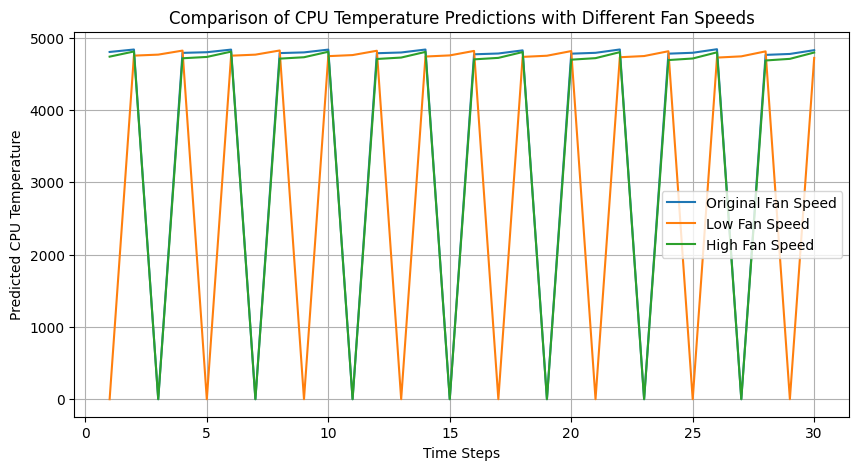

: 

In [ ]:
low_fan_speed = 0.2  # Set a low value within scaled range
high_fan_speed = 0.8  # Set a high value within scaled range

predictions_df = evaluate_model_with_fan_speed_variation(model, test_loader, scaler, df, k_step, split_index, low_fan_speed, high_fan_speed)


In [22]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score

def evaluate_model(model, test_loader, scaler, df, k_step, outputs, split_index):
    model.eval()
    criterion = nn.MSELoss()
    test_loss = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:
            outputs = model(batch_features, batch_exogenous)
            loss = criterion(outputs.unsqueeze(2), batch_outputs)
            test_loss += loss.item()
            predictions.append(outputs.numpy())
            actuals.append(batch_outputs.numpy())
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

    # Convert predictions and actuals to numpy array and rescale
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # Create a dataframe using the original dataframe index and actual values
    actual_df = df.iloc[split_index:split_index + len(actuals)].copy()
    for i in range(k_step):
        actual_df[f'actual_cpu_temp_{i+1}'] = actuals[:,i,0]

    # Create a dataframe from predictions using the same index as the actual values
    predictions_df = actual_df.copy()
    for i in range(k_step):
        predictions_df[f'predicted_cpu_temp_{i+1}'] = predictions[:,i]

    #Inverse scale the predicted and actual values
    for i in range(k_step):
        original_data = scaler.inverse_transform(predictions_df[['cpu_temp','inlet_temp', 'it_power', f'predicted_cpu_temp_{i+1}']].values)
        predictions_df[f'predicted_cpu_temp_{i+1}'] = original_data[:,-1]

        original_data_actual = scaler.inverse_transform(actual_df[['cpu_temp','inlet_temp', 'it_power', f'actual_cpu_temp_{i+1}']].values)
        predictions_df[f'actual_cpu_temp_{i+1}'] = original_data_actual[:,-1]

    predictions_df.reset_index(inplace=True)

    # Calculate R2 scores
    r2_scores = []
    for i in range(k_step):
        r2 = r2_score(predictions_df[f'actual_cpu_temp_{i+1}'], predictions_df[f'predicted_cpu_temp_{i+1}'])
        r2_scores.append(r2)
        print(f"R2 Score for Step {i+1}: {r2:.4f}")
    average_r2 = np.mean(r2_scores)
    print(f"Average R2 Score: {average_r2:.4f}")

    rmse_scores = []
    for i in range(k_step):
        mse = np.mean((predictions_df[f'actual_cpu_temp_{i+1}'] - predictions_df[f'predicted_cpu_temp_{i+1}']) ** 2)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        print(f"RMSE for Step {i+1}: {rmse:.4f}")
    average_rmse = np.mean(rmse_scores)
    print(f"Average RMSE: {average_rmse:.4f}")

    return predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse

In [23]:
import matplotlib.pyplot as plt

def plot_results(predictions_df, history, k_step, r2_scores):
    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        plt.plot(predictions_df[f'predicted_cpu_temp_{i+1}'], label=f'Predicted CPU Temp {i+1}', color='red')
        plt.plot(predictions_df[f'actual_cpu_temp_{i+1}'], label=f'Actual CPU Temp {i+1}', color='blue', alpha=0.6)
        
        # Increase font size for axis labels and title
        plt.xlabel('Time Step', fontsize=14)
        plt.ylabel('CPU Temperature (°C)', fontsize=14)
        plt.title(f'Predicted vs Actual CPU Temperature - Step {i+1}, R2: {r2_scores[i]:.4f}', fontsize=16)
        
        # Increase font size for legend
        plt.legend(fontsize=12)
        plt.show()

    # Plotting training and test loss
    plt.figure(figsize=(12, 6))
    plt.plot(history['train_loss'], label='Training Loss', color='green')
    plt.plot(history['test_loss'], label='Test Loss', color='orange')
    
    # Increase font size for axis labels and title
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('MSE Loss', fontsize=14)
    plt.title('Training vs Test Loss', fontsize=16)
    
    # Increase font size for legend
    plt.legend(fontsize=12)
    plt.show()


In [24]:
predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse = evaluate_model(trained_model, test_loader, scalers["cpu_temp"], combined_df, k_step, outputs, split_index)

Test Loss: 0.0040
R2 Score for Step 1: 0.9365
R2 Score for Step 2: 0.9659
R2 Score for Step 3: 0.9617
R2 Score for Step 4: 0.9589
R2 Score for Step 5: 0.9564
R2 Score for Step 6: 0.9544
R2 Score for Step 7: 0.9529
R2 Score for Step 8: 0.9519
R2 Score for Step 9: 0.9513
R2 Score for Step 10: 0.9511
R2 Score for Step 11: 0.9511
R2 Score for Step 12: 0.9510
R2 Score for Step 13: 0.9513
R2 Score for Step 14: 0.9514
R2 Score for Step 15: 0.9515
R2 Score for Step 16: 0.9516
R2 Score for Step 17: 0.9527
R2 Score for Step 18: 0.9536
R2 Score for Step 19: 0.9549
R2 Score for Step 20: 0.9564
R2 Score for Step 21: 0.9580
R2 Score for Step 22: 0.9596
R2 Score for Step 23: 0.9610
R2 Score for Step 24: 0.9621
R2 Score for Step 25: 0.9626
R2 Score for Step 26: 0.9627
R2 Score for Step 27: 0.9619
R2 Score for Step 28: 0.9608
R2 Score for Step 29: 0.9593
R2 Score for Step 30: 0.9578
Average R2 Score: 0.9558
RMSE for Step 1: 2.1497
RMSE for Step 2: 1.5765
RMSE for Step 3: 1.6742
RMSE for Step 4: 1.7399


In [19]:
predictions_df.to_csv("../data/predictions_df.csv", index=False)

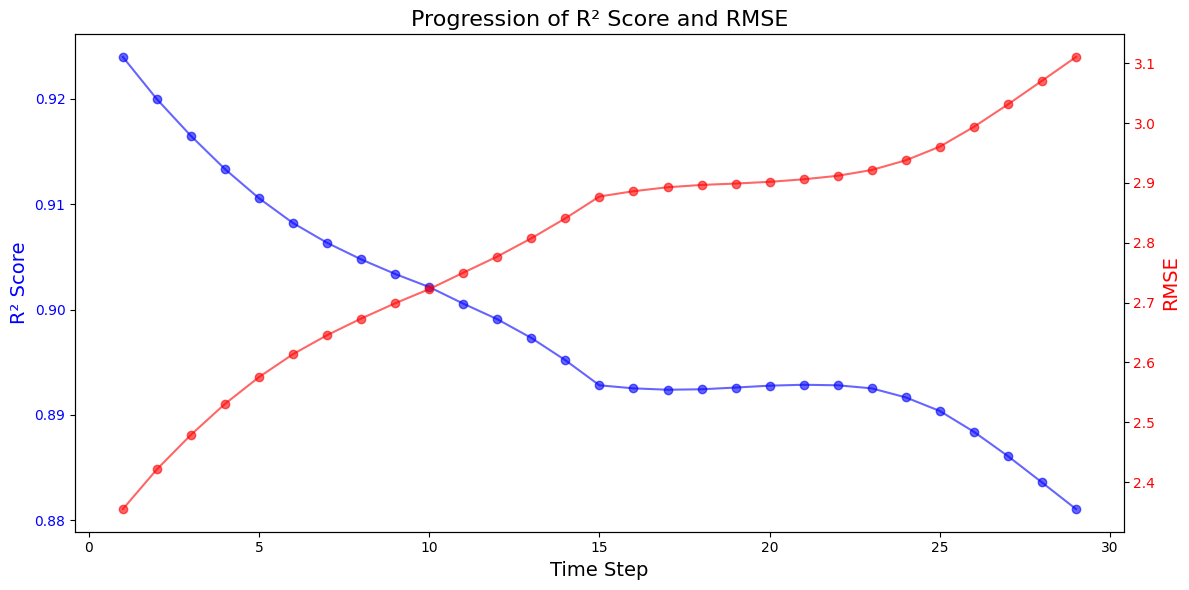

In [20]:
import matplotlib.pyplot as plt

def plot_r2_rmse_progression(r2_scores, rmse_scores):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # X-axis label with increased font size
    ax1.set_xlabel('Time Step', fontsize=14)
    # Y-axis label for R² Score with increased font size
    ax1.set_ylabel('R² Score', color='b', fontsize=14)
    ax1.plot(range(1, len(r2_scores) + 1), r2_scores, color='blue', alpha=0.6, label='R² Score', marker='o')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Y-axis label for RMSE with increased font size
    ax2 = ax1.twinx()
    ax2.set_ylabel('RMSE', color='r', fontsize=14)
    ax2.plot(range(1, len(rmse_scores) + 1), rmse_scores, color='red', alpha=0.6, label='RMSE', marker='o')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title with increased font size
    plt.title('Progression of R² Score and RMSE', fontsize=16)

    plt.tight_layout()
    plt.show()

plot_r2_rmse_progression(r2_scores[1:], rmse_scores[1:])


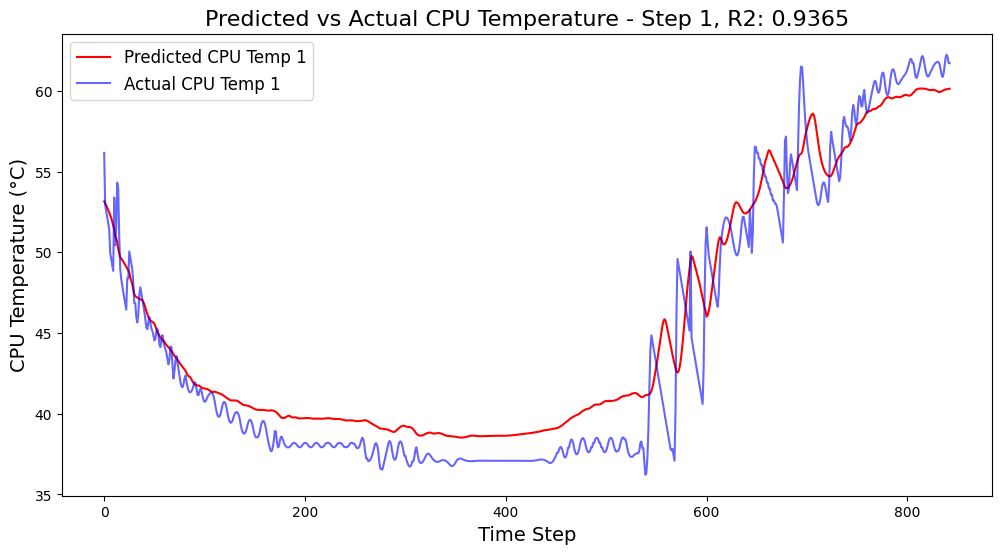

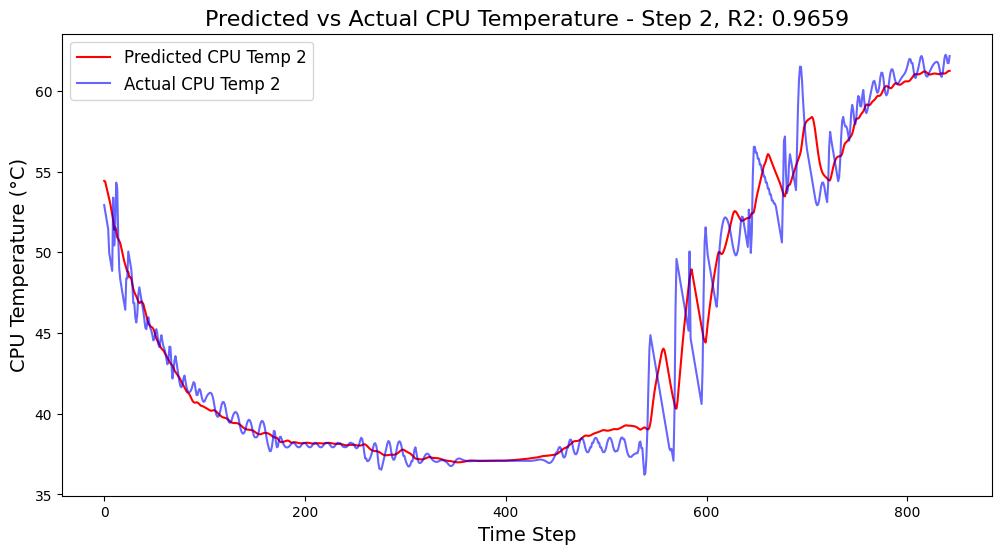

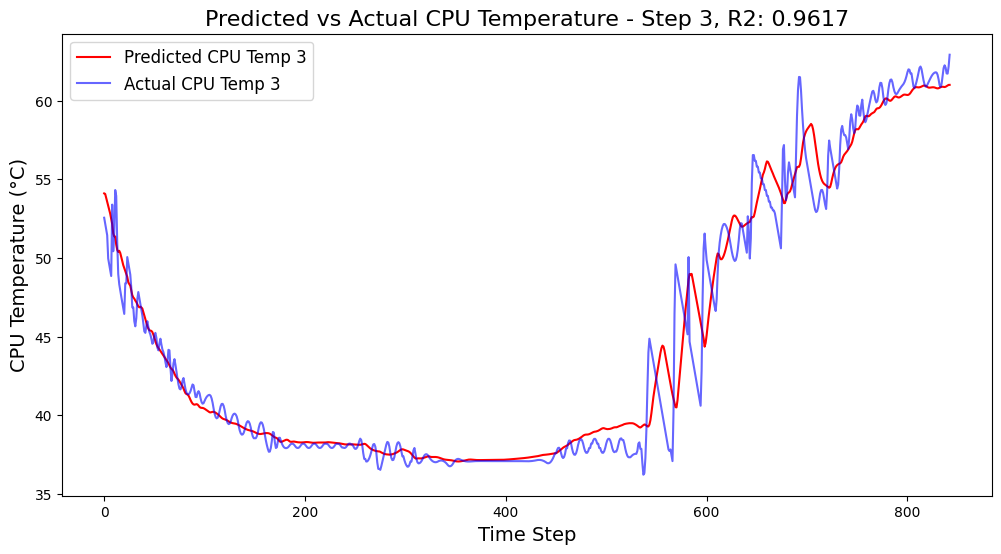

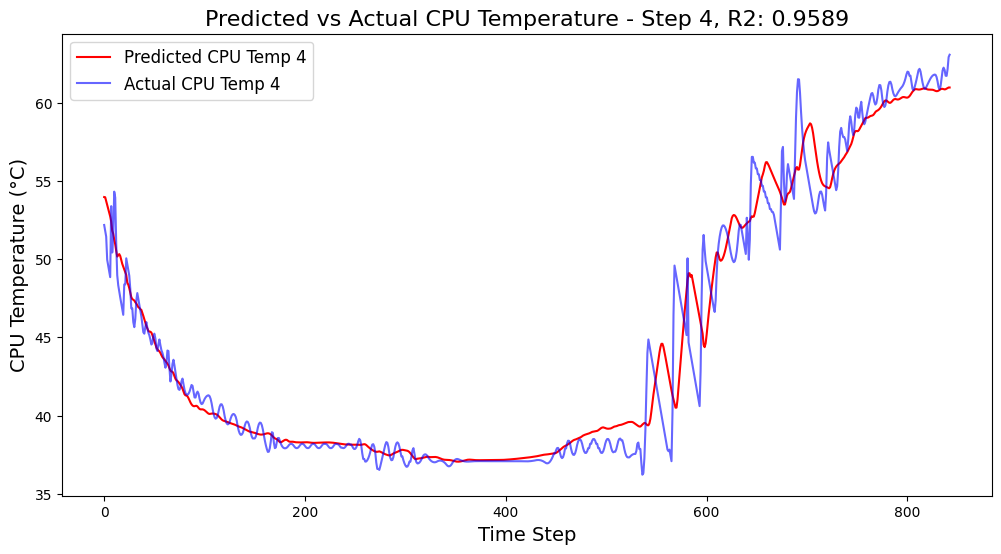

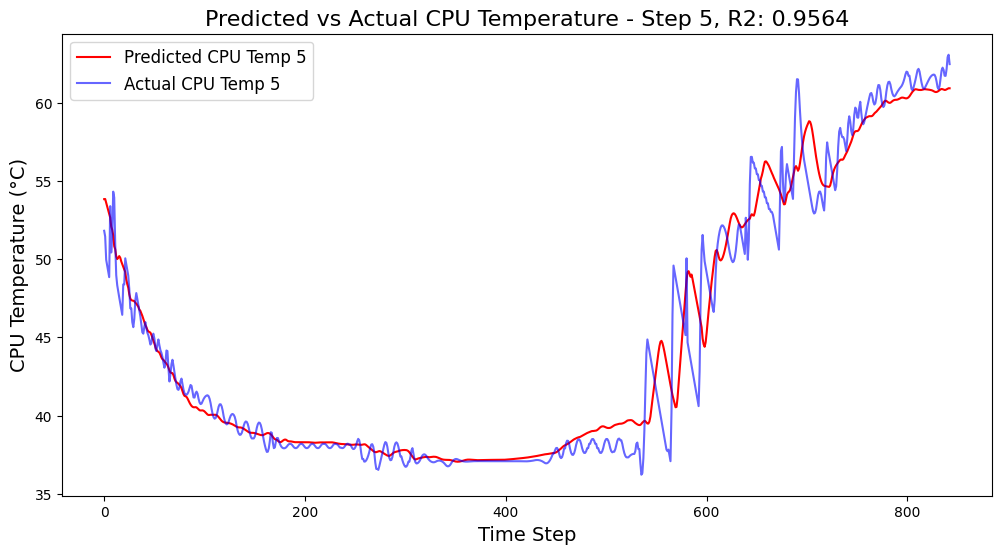

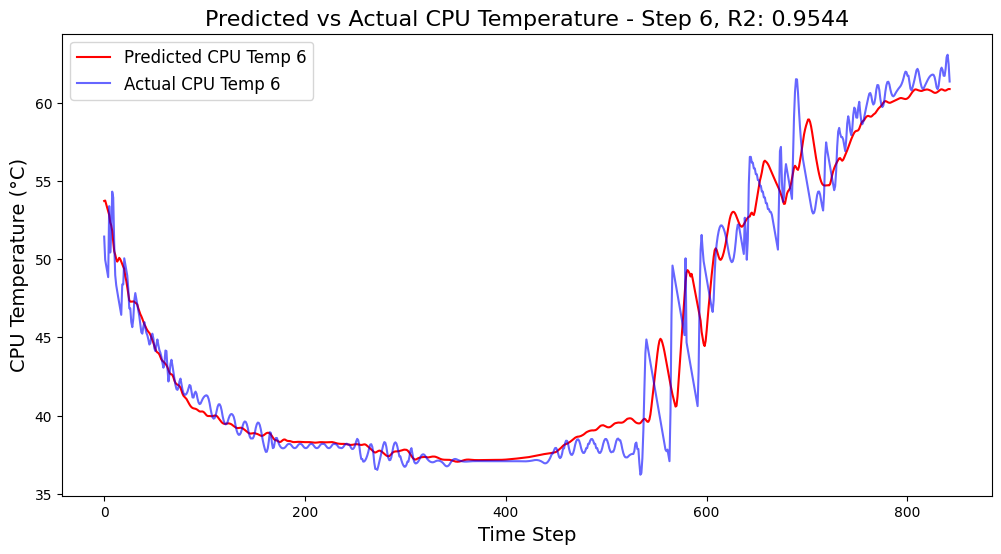

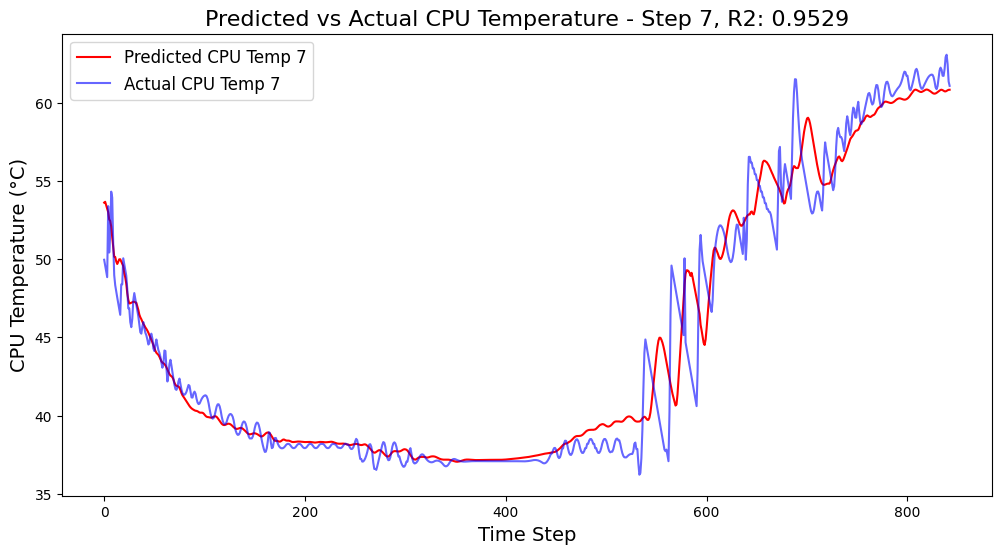

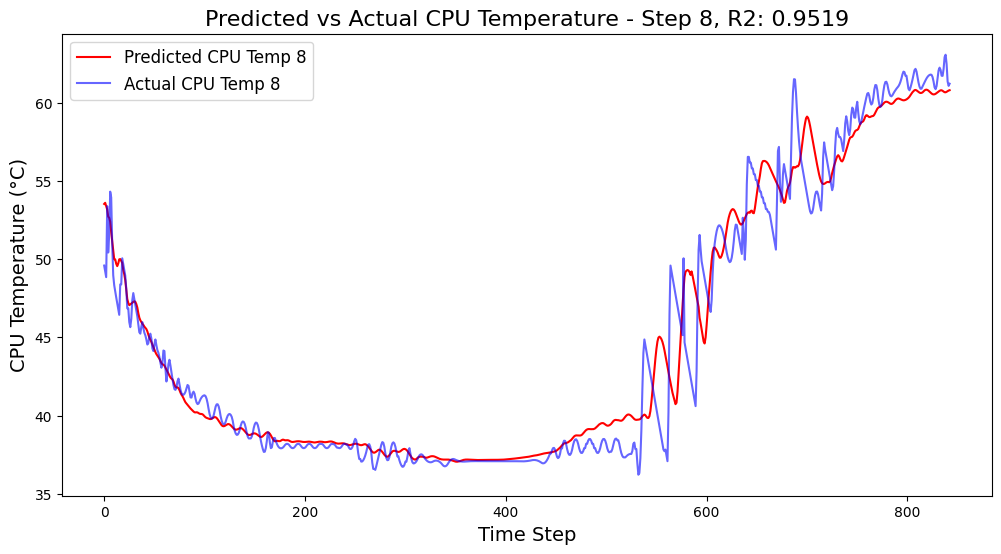

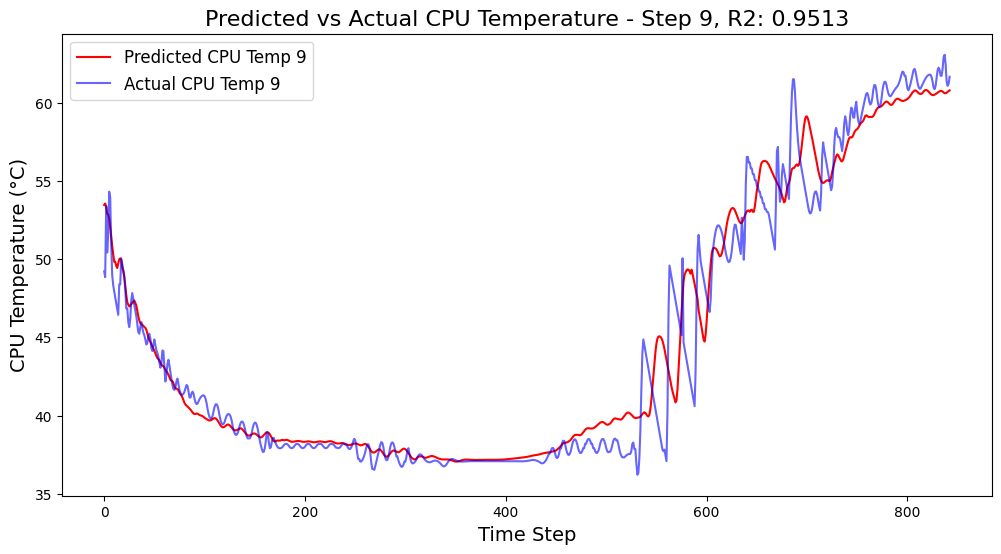

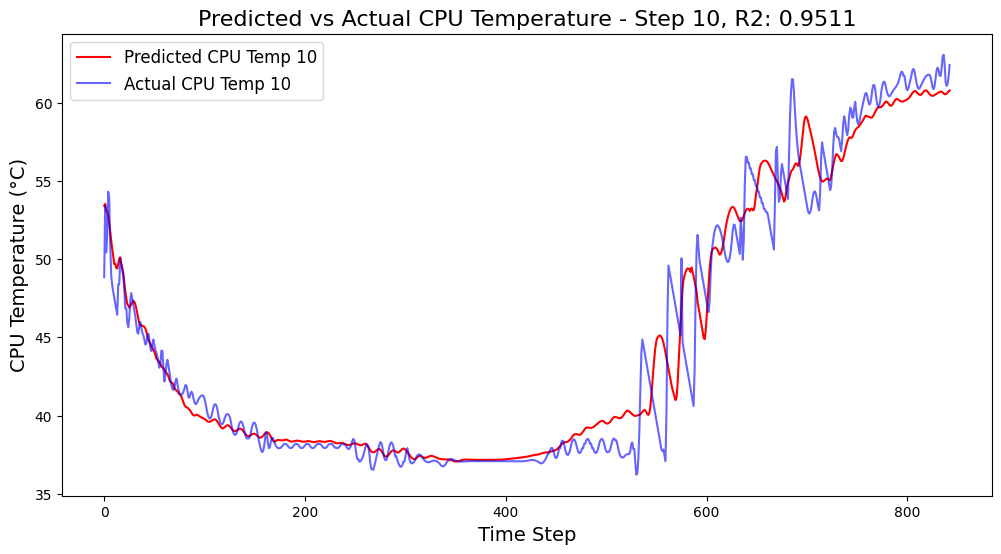

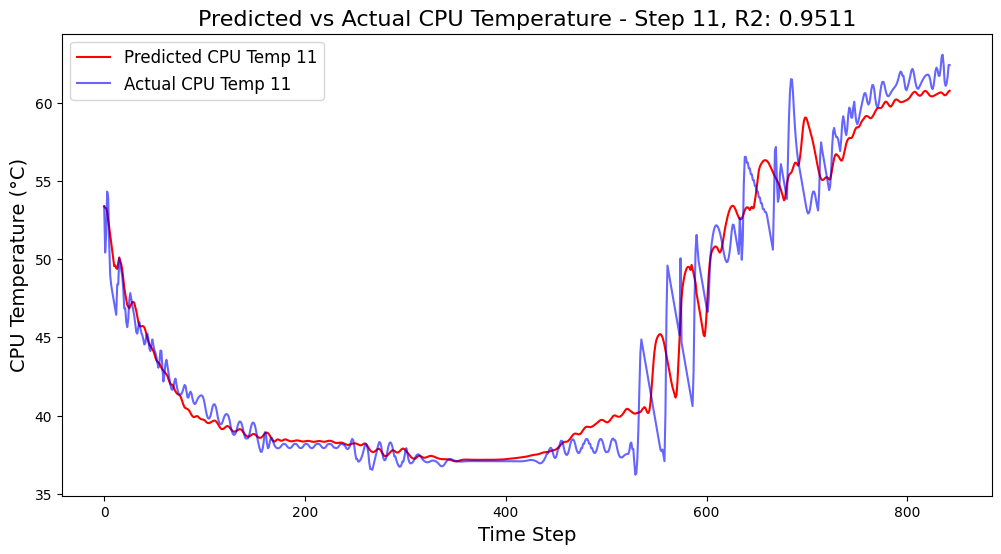

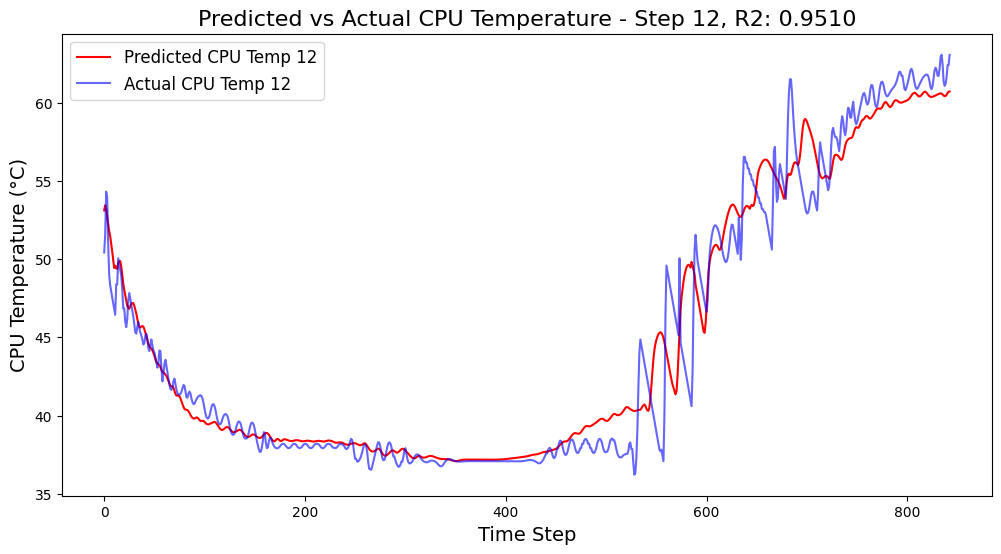

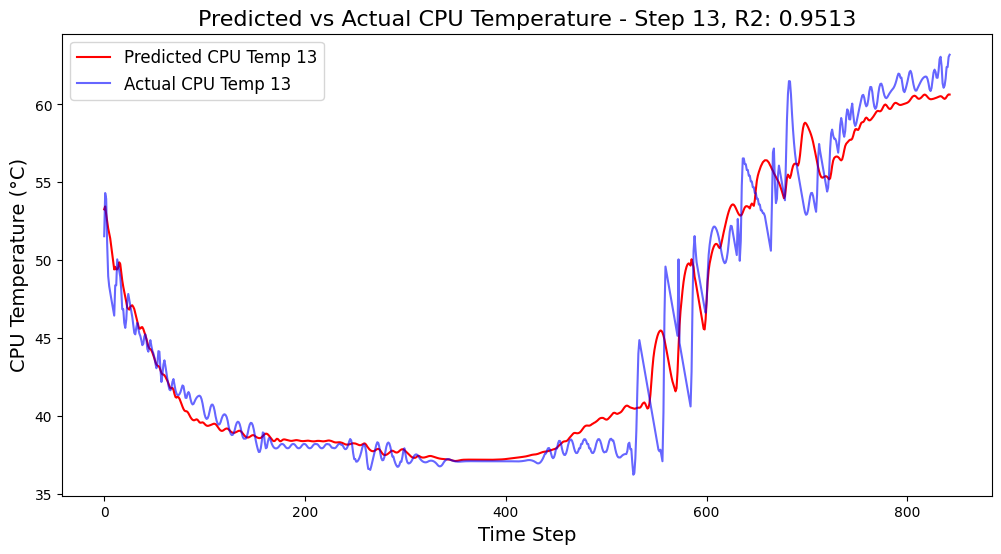

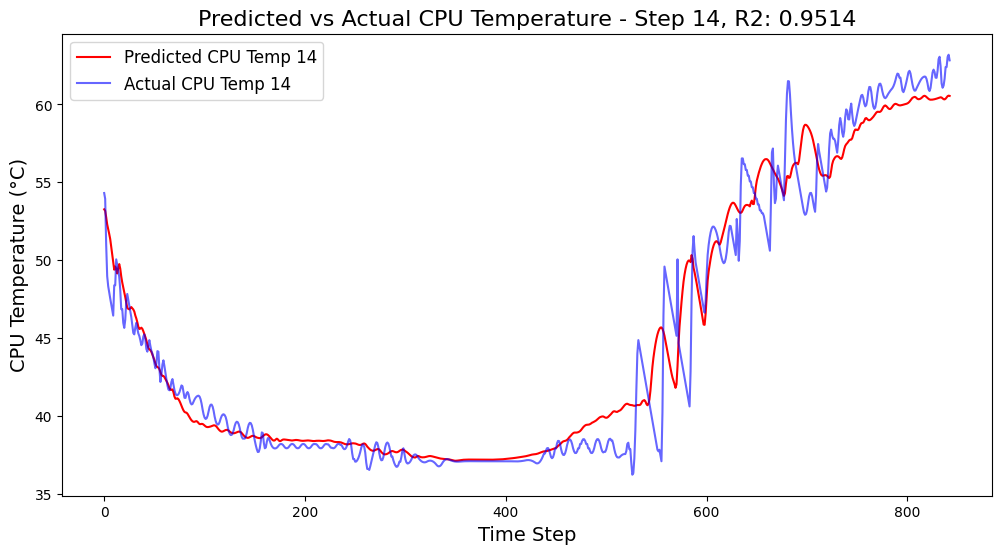

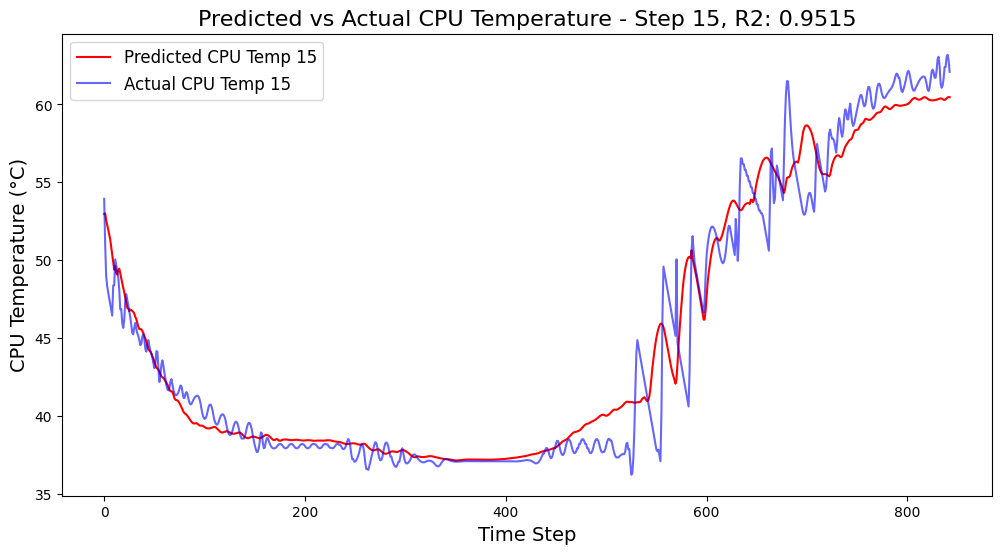

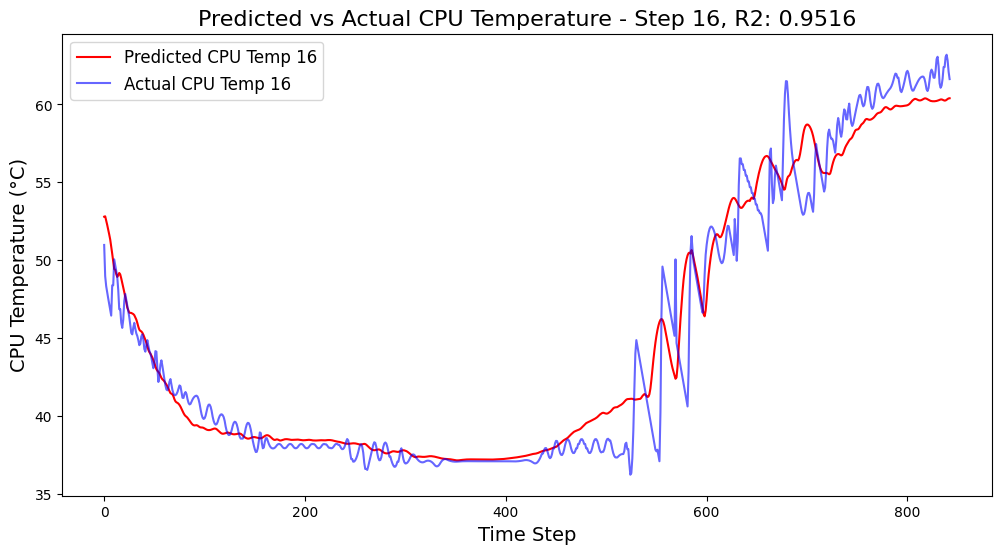

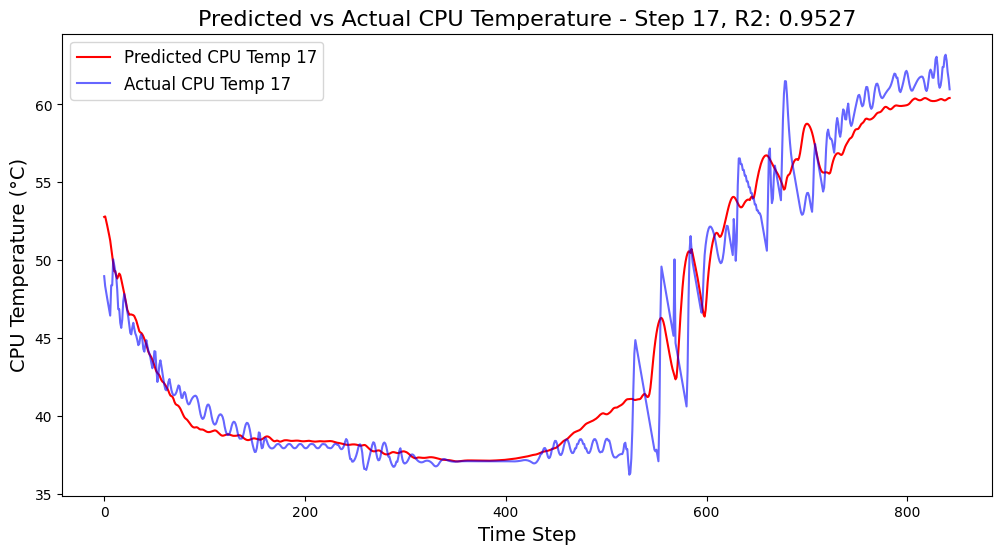

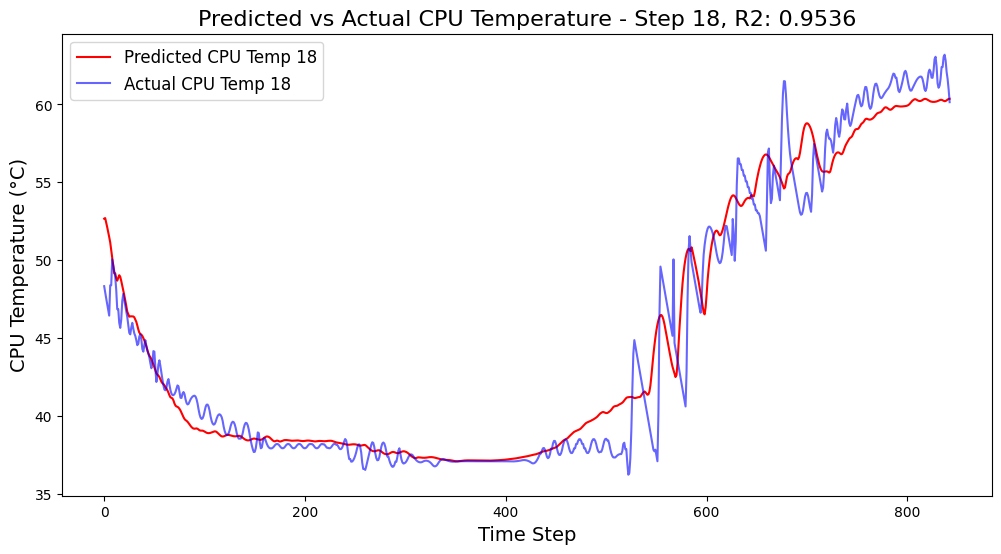

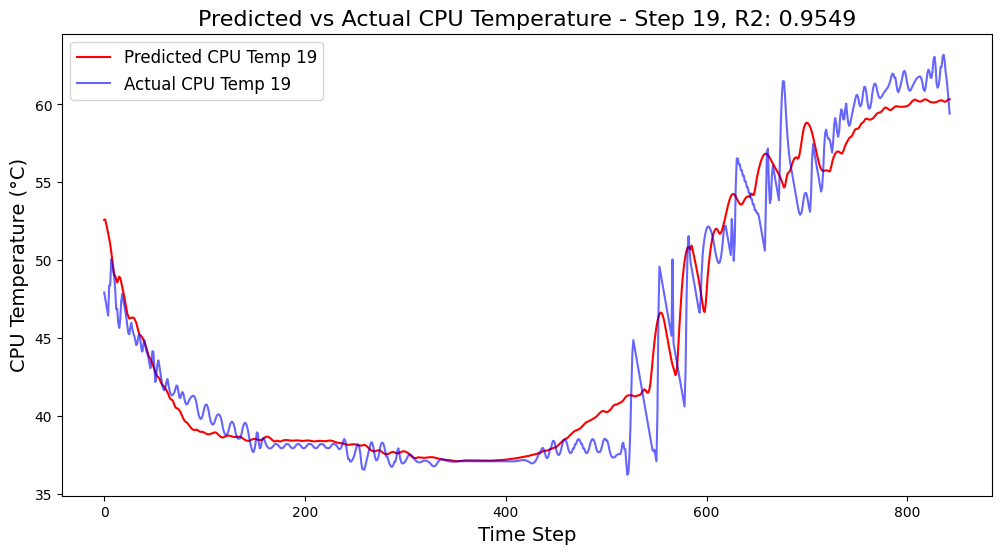

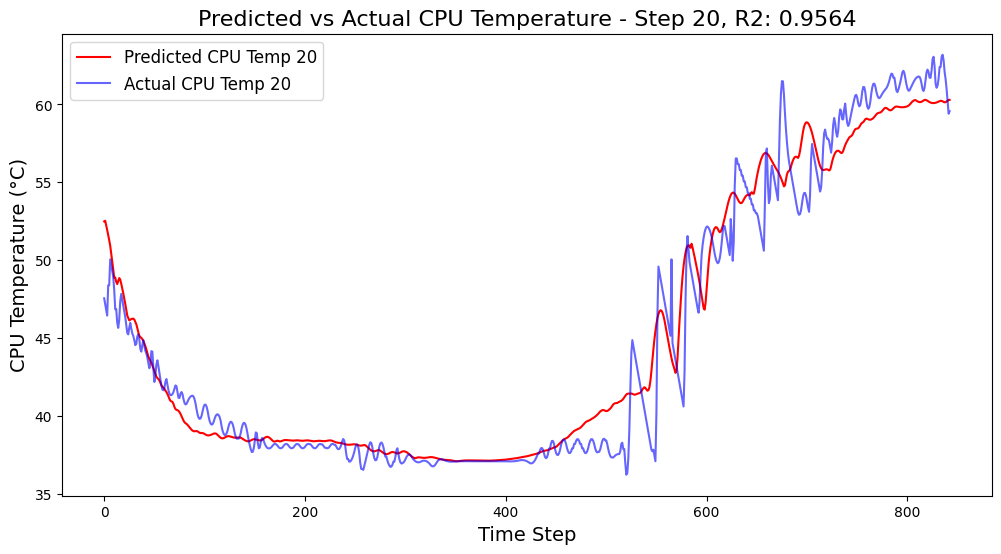

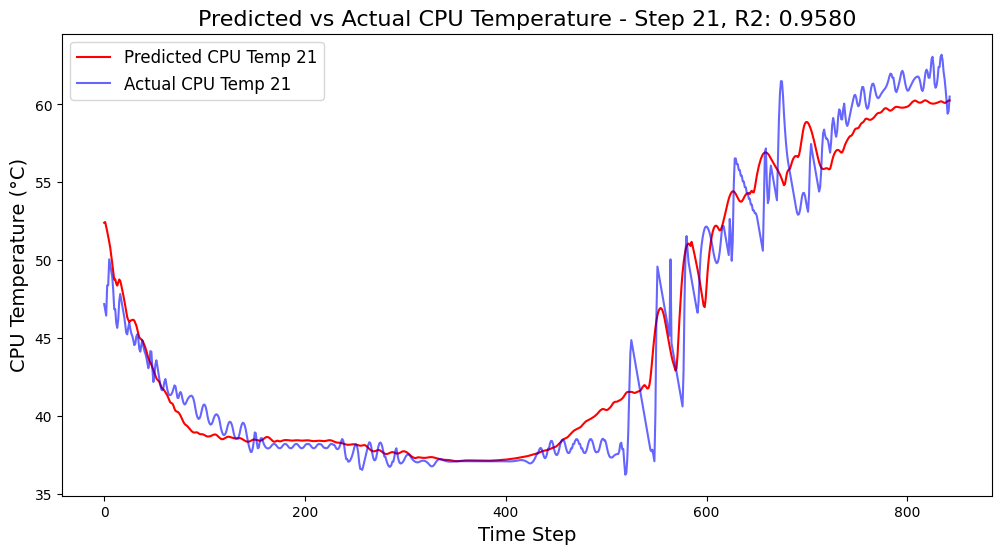

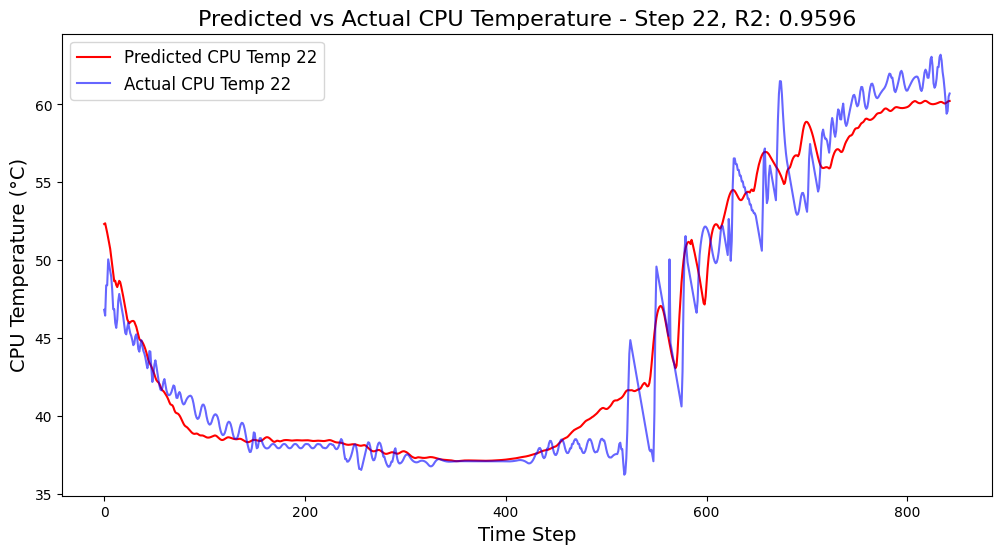

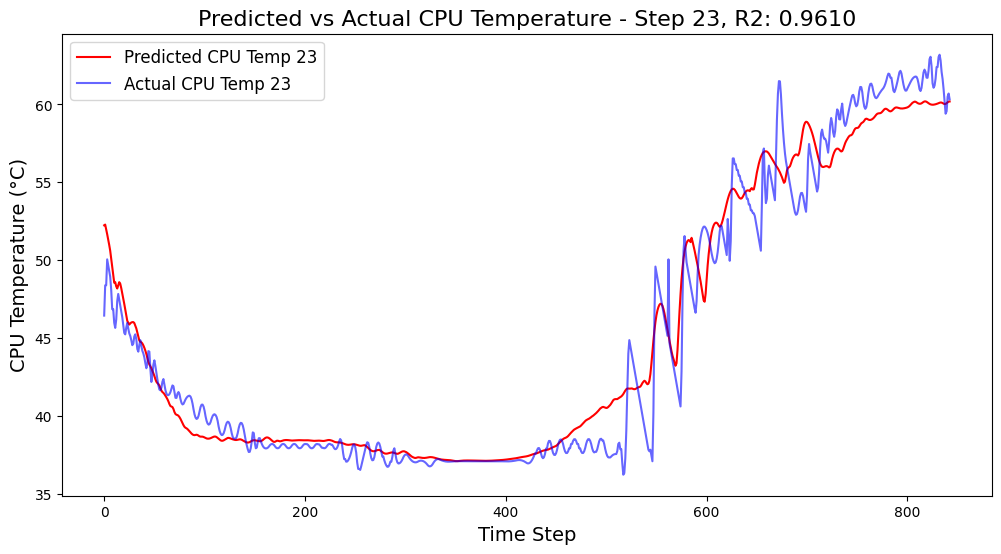

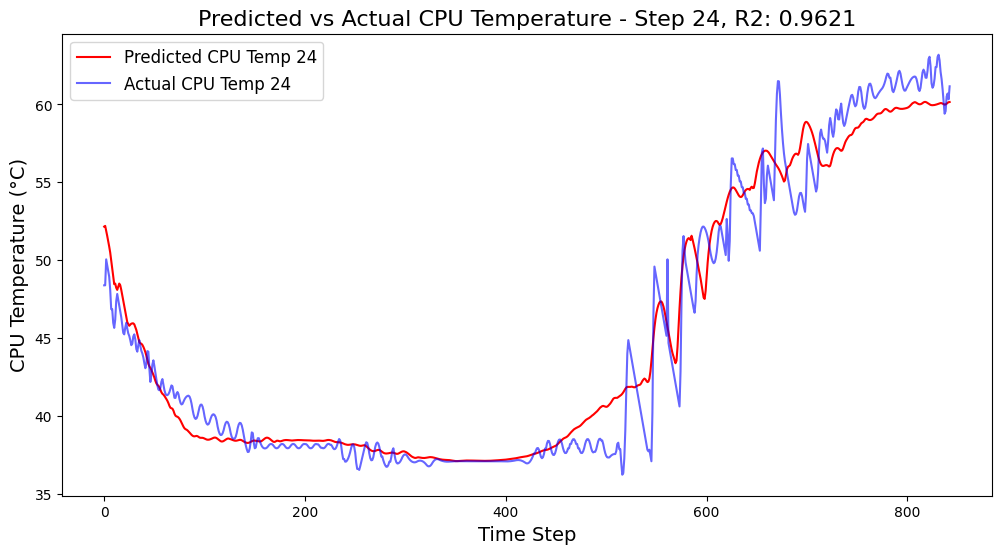

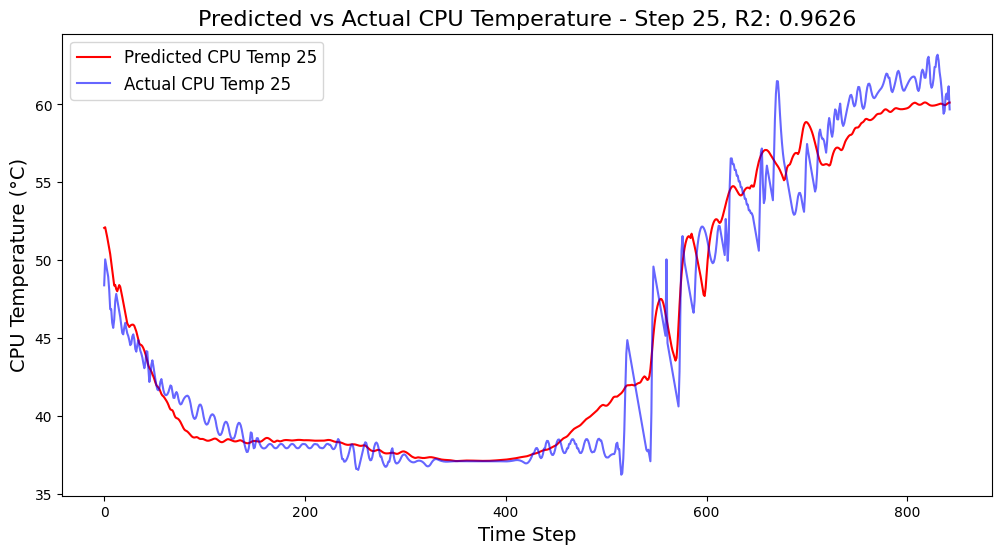

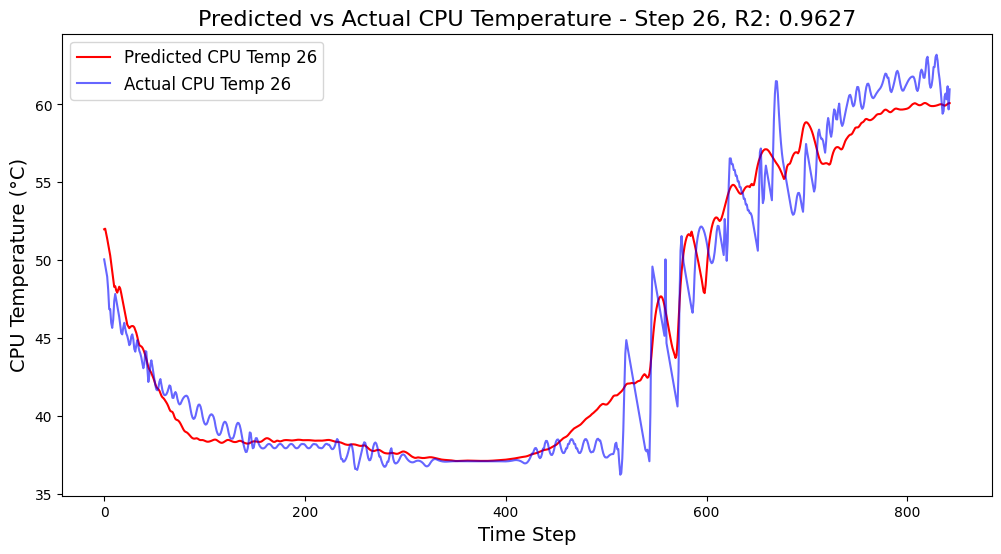

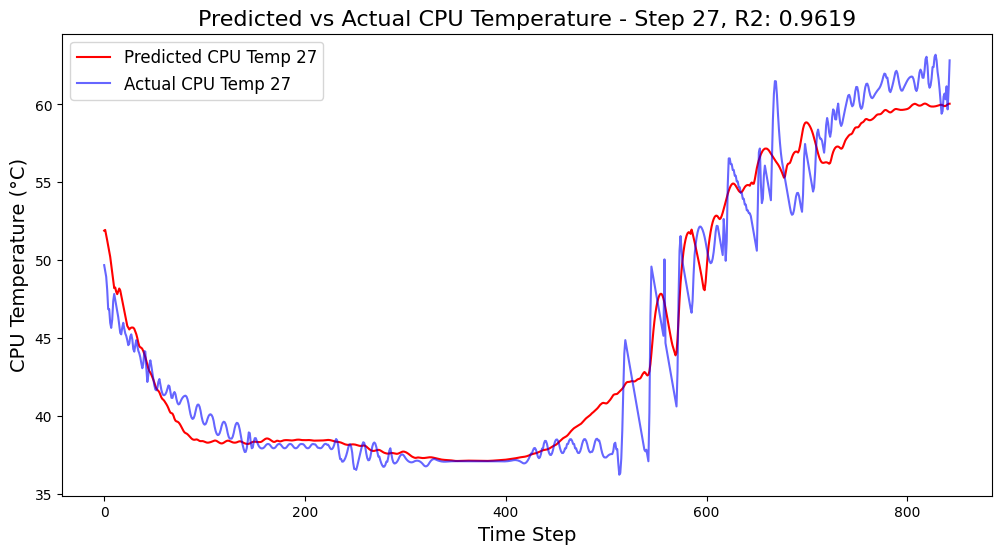

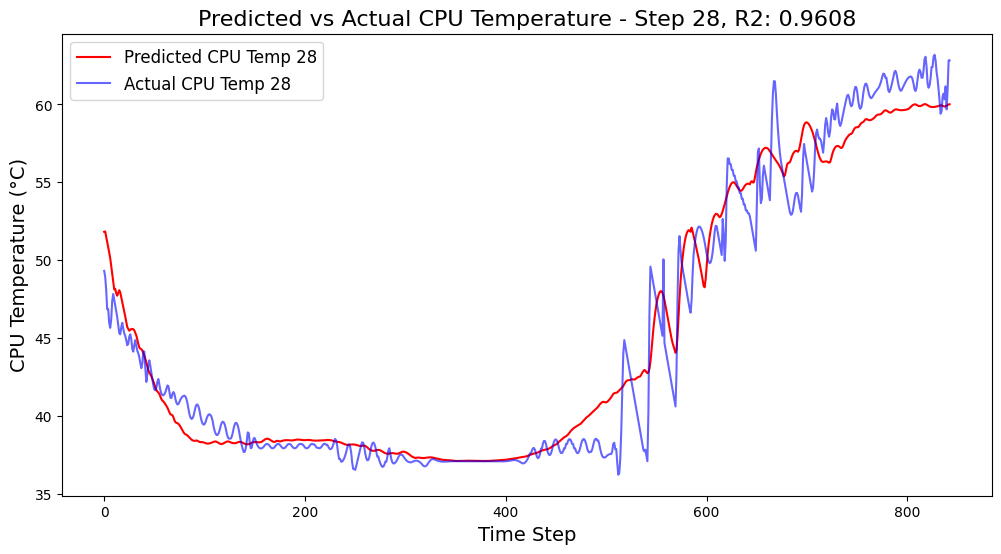

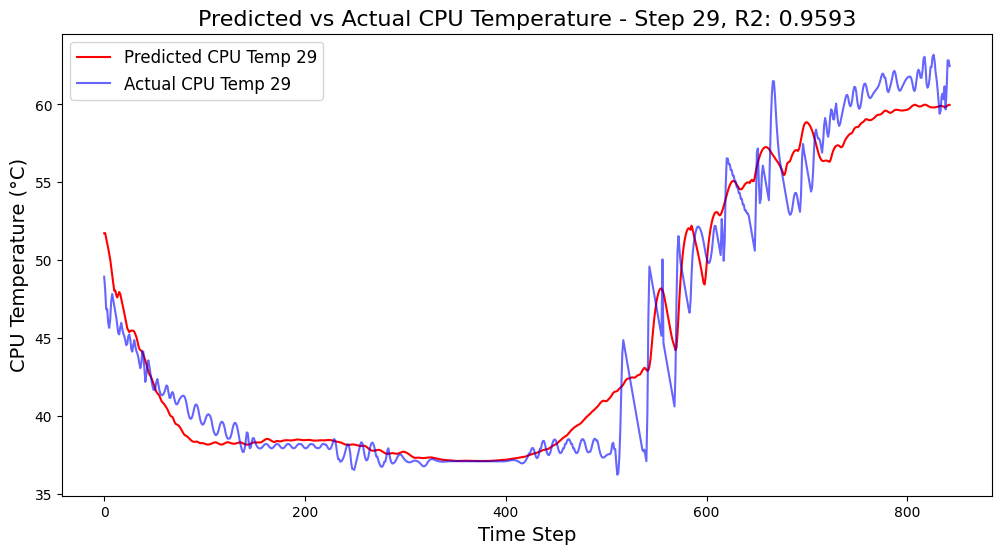

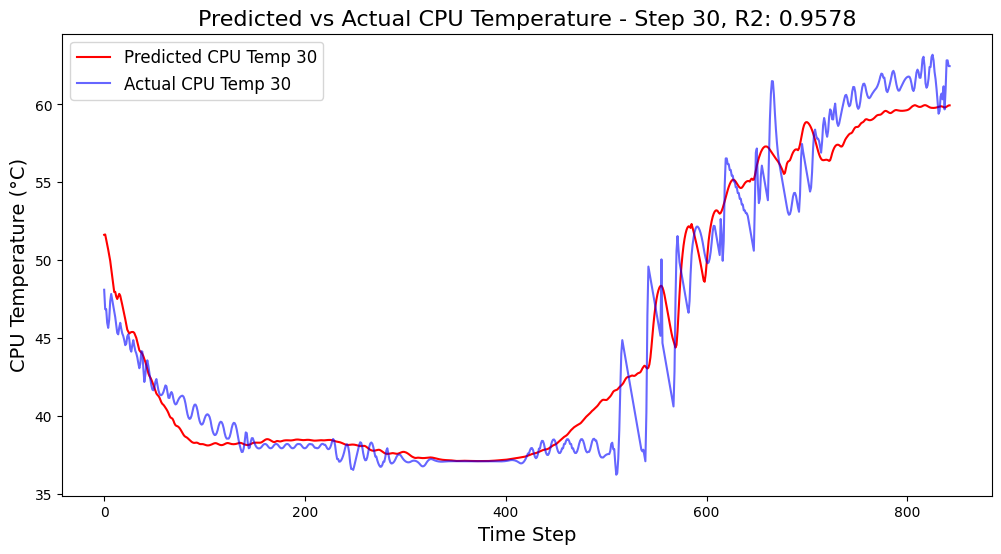

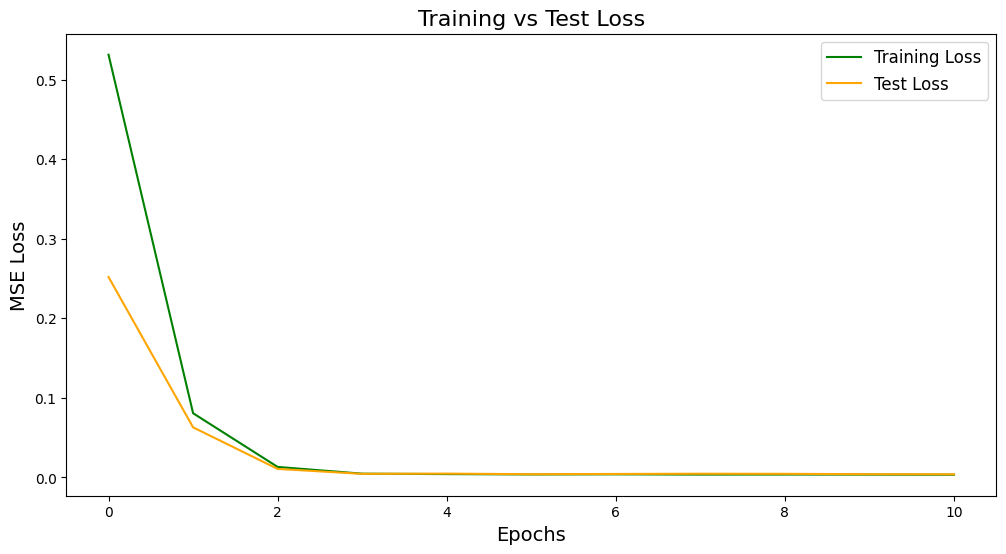

In [20]:
plot_results(predictions_df, history, k_step, r2_scores)

In [112]:
import matplotlib.pyplot as plt
import numpy as np

def plot_residuals(predictions, actuals, k_step):
    # Flatten the predictions and actuals for plotting residuals over all steps
    residuals = predictions - actuals

    # Plotting residuals for each step separately
    plt.figure(figsize=(10, 6))
    
    # Loop through each step in the prediction horizon and plot residuals
    for i in range(k_step):
        plt.plot(residuals[:, i], label=f'Residuals for Step {i+1}', linestyle='--')

    plt.axhline(0, color='black', linestyle='-', linewidth=2)  # Line at 0 for reference
    plt.title('Residuals Plot (Prediction Errors)')
    plt.xlabel('Time Step')
    plt.ylabel('Residual (Predicted - Actual)')
    plt.legend()
    plt.show()

    # Optionally, you can also plot a histogram of the residuals for each step
    plt.figure(figsize=(8, 6))
    for i in range(k_step):
        plt.hist(residuals[:, i], bins=50, alpha=0.7, label=f'Residuals for Step {i+1}')
    
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


def plot_prediction_interval(predictions, actuals, k_step=3, confidence_interval=95):
    """
    Plots the prediction interval with upper and lower bounds.

    Args:
        predictions (ndarray): The predicted values.
        actuals (ndarray): The actual values.
        k_step (int): The number of prediction steps (e.g., 30-step ahead).
        confidence_interval (int): The confidence interval (default is 95%).
    """
    # Calculate the upper and lower bounds for the prediction interval
    lower_bound = predictions - (1.96 * np.std(predictions, axis=0))  # 95% confidence interval
    upper_bound = predictions + (1.96 * np.std(predictions, axis=0))  # 95% confidence interval

    # Make sure the predictions and actuals are of the same length
    if predictions.shape[0] != actuals.shape[0]:
        raise ValueError("The number of predictions and actuals must be the same length.")

    # Create a time range for plotting
    time_steps = np.arange(predictions.shape[0])

    plt.figure(figsize=(10, 6))

    # Plot actual values
    plt.plot(time_steps, actuals, label='Actual', color='blue', alpha=0.7)

    # Plot predicted values
    plt.plot(time_steps, predictions, label='Predicted', color='green', alpha=0.7)

    # Fill the area between lower and upper bounds to indicate uncertainty
    plt.fill_between(time_steps, lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.2,
                     label=f'{confidence_interval}% Prediction Interval')

    plt.title(f'Prediction Interval with {confidence_interval}% Confidence')
    plt.xlabel('Time Step')
    plt.ylabel('Temperature (°C)')
    plt.legend(loc='upper left')
    plt.show()




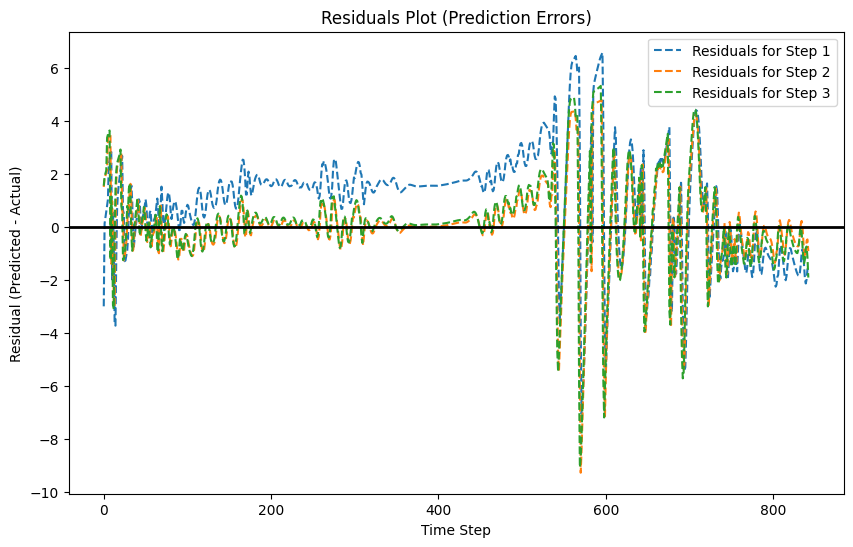

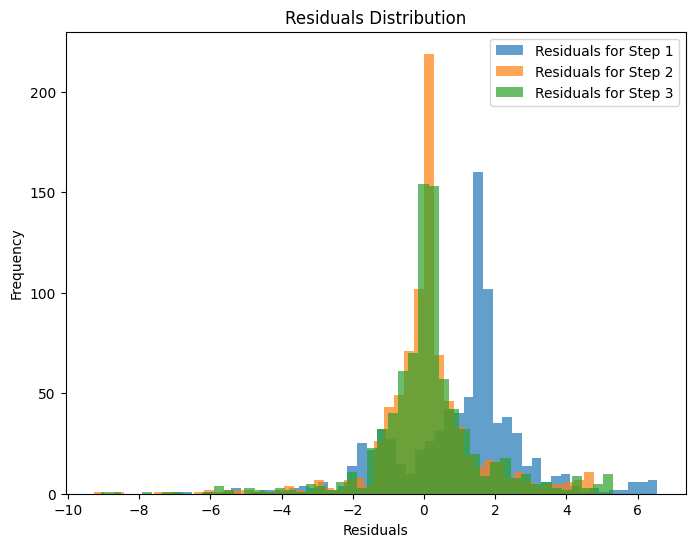

ValueError: operands could not be broadcast together with shapes (843,) (2529,) 

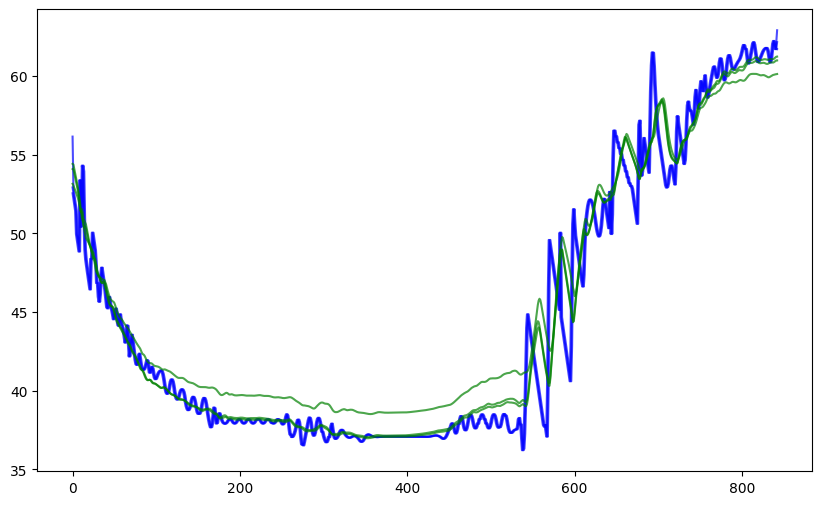

In [113]:
# Assuming predictions_df and actual_df are the predicted and actual temperature values
predictions = predictions_df[['predicted_cpu_temp_1', 'predicted_cpu_temp_2', 'predicted_cpu_temp_3']].values
actuals = predictions_df[['actual_cpu_temp_1', 'actual_cpu_temp_2', 'actual_cpu_temp_3']].values

# Residual Plot
plot_residuals(predictions, actuals, k_step=3)

# Prediction Interval Uncertainty Plot
plot_prediction_interval(predictions, actuals, k_step=3, confidence_interval=95)


: 

In [32]:
# analysis on input window vs prediction horizon

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def train_and_evaluate_model_with_varying_input_length(
    k_step,
    r2_threshold,
    history_lengths,
    device=torch.device("cpu"),
    learning_rate=0.001,
    num_epochs=20,
    step=1,
):
    results = {}

    for history_length in history_lengths:
        print(f"Evaluating for history length: {history_length}")
        k_step_current = k_step
        below_threshold = False

        while not below_threshold:
            print(f"  Trying prediction horizon: {k_step_current}")

            # Prepare data loaders with the current history length and prediction horizon
            train_loader, test_loader, outputs, split_index = prepare_data(
                df_scaled, seq_length=history_length, k_step=k_step_current
            )

            # Define and train the model
            model = DualInputAttentionLSTM(input_size=3, lstm_hidden_size=128, dense_hidden_size=64, k_step=k_step_current)
            model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            criterion = nn.MSELoss()

            for epoch in range(num_epochs):
                model.train()
                for batch_features, batch_exogenous, batch_outputs in train_loader:
                    batch_features, batch_exogenous, batch_outputs = (
                        batch_features.to(device),
                        batch_exogenous.to(device),
                        batch_outputs.to(device),
                    )

                    optimizer.zero_grad()
                    outputs = model(batch_features, batch_exogenous)
                    loss = criterion(outputs.unsqueeze(2), batch_outputs)
                    loss.backward()
                    optimizer.step()

            # Evaluate the model
            predictions, actuals = [], []
            model.eval()
            with torch.no_grad():
                for batch_features, batch_exogenous, batch_outputs in test_loader:
                    batch_features, batch_exogenous, batch_outputs = (
                        batch_features.to(device),
                        batch_exogenous.to(device),
                        batch_outputs.to(device),
                    )

                    outputs = model(batch_features, batch_exogenous)
                    predictions.append(outputs.cpu().numpy())
                    actuals.append(batch_outputs.cpu().numpy())

            predictions = np.concatenate(predictions, axis=0)
            actuals = np.concatenate(actuals, axis=0)

            # Compute R2 scores
            r2_scores = []
            for i in range(k_step_current):
                r2 = r2_score(actuals[:, i, 0], predictions[:, i])
                r2_scores.append(r2)

            # average_r2 = np.mean(r2_scores)
            final_r2 = r2_scores[-1]
            print(f"    R2 Score for Step {k_step_current}: {final_r2:.4f}")
            # print(f"    Average R2: {average_r2:.4f}")

            # Check if the average R2 score falls below the threshold
            if final_r2 < r2_threshold:
                below_threshold = True
                results[history_length] = k_step_current - step
                print(f"    R2 below threshold. Max prediction horizon: {results[history_length]}\n")
            else:
                k_step_current += step

    return results

In [66]:
history_lengths = [5, 10, 15, 20, 25, 30, 35, 40]
r2_threshold = 0.95
k_step_initial = 5

results = train_and_evaluate_model_with_varying_input_length(
    k_step=k_step_initial,
    r2_threshold=r2_threshold,
    history_lengths=history_lengths,
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    learning_rate=0.001,
    num_epochs=10, 
    step=5
)

Evaluating for history length: 5
  Trying prediction horizon: 5
    R2 Score for Step 5: 0.9607
  Trying prediction horizon: 10
    R2 Score for Step 10: 0.8686
    R2 below threshold. Max prediction horizon: 5

Evaluating for history length: 10
  Trying prediction horizon: 5
    R2 Score for Step 5: 0.9594
  Trying prediction horizon: 10
    R2 Score for Step 10: 0.9465
    R2 below threshold. Max prediction horizon: 5

Evaluating for history length: 15
  Trying prediction horizon: 5
    R2 Score for Step 5: 0.9619
  Trying prediction horizon: 10
    R2 Score for Step 10: 0.9526
  Trying prediction horizon: 15
    R2 Score for Step 15: 0.9546
  Trying prediction horizon: 20
    R2 Score for Step 20: 0.9527
  Trying prediction horizon: 25
    R2 Score for Step 25: 0.9508
  Trying prediction horizon: 30
    R2 Score for Step 30: 0.9227
    R2 below threshold. Max prediction horizon: 25

Evaluating for history length: 20
  Trying prediction horizon: 5
    R2 Score for Step 5: 0.9617
  Tr

In [2]:
results = {
    5: 5,
    10: 5,
    15: 25,
    20: 15, 
    25: 25,
    30: 25, 
    35: 20,
    40: 25
}

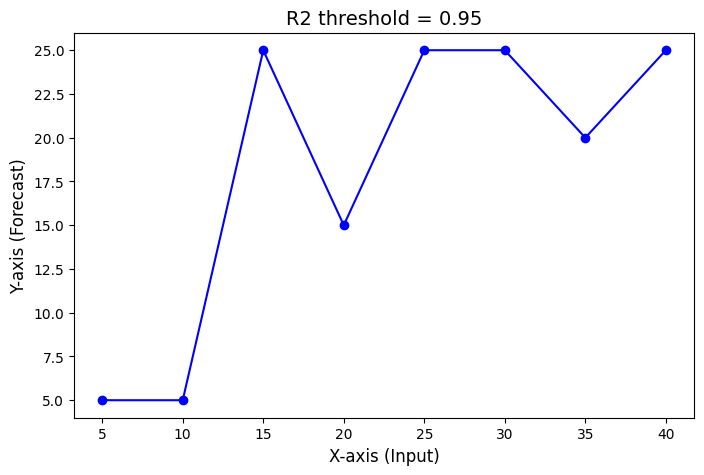

In [7]:
x = list(results.keys())
y = list(results.values())

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', color='b')
plt.xlabel("X-axis (Input)", fontsize=12)
plt.ylabel("Y-axis (Forecast)", fontsize=12)
plt.title("R2 threshold = 0.95", fontsize=14)
# plt.grid(True)
plt.show()

In [33]:
history_lengths = [5, 10, 15, 20, 25, 30, 35, 40]
r2_threshold = 0.9
k_step_initial = 10

results = train_and_evaluate_model_with_varying_input_length(
    k_step=k_step_initial,
    r2_threshold=r2_threshold,
    history_lengths=history_lengths,
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    learning_rate=0.001,
    num_epochs=10, 
    step=10
)

Evaluating for history length: 5
  Trying prediction horizon: 10
    R2 Score for Step 10: 0.9245
  Trying prediction horizon: 20
    R2 Score for Step 20: 0.8569
    R2 below threshold. Max prediction horizon: 10

Evaluating for history length: 10
  Trying prediction horizon: 10
    R2 Score for Step 10: 0.9353
  Trying prediction horizon: 20
    R2 Score for Step 20: 0.9471
  Trying prediction horizon: 30
    R2 Score for Step 30: 0.9336
  Trying prediction horizon: 40
    R2 Score for Step 40: 0.8912
    R2 below threshold. Max prediction horizon: 30

Evaluating for history length: 15
  Trying prediction horizon: 10
    R2 Score for Step 10: 0.9527
  Trying prediction horizon: 20
    R2 Score for Step 20: 0.9547
  Trying prediction horizon: 30
    R2 Score for Step 30: 0.9465
  Trying prediction horizon: 40
    R2 Score for Step 40: 0.9313
  Trying prediction horizon: 50
    R2 Score for Step 50: 0.8818
    R2 below threshold. Max prediction horizon: 40

Evaluating for history lengt